### CPS_PECERT_Mapper

Updated March 11, 2018

Brian Dew @bd_econ

Map how people respond to question about whether they have a professional certification.

TO DO:

Need to clean up code, replace set_values with at, etc.

In [11]:
# Import packages 
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap as Basemap
# Settings for the map

os.chdir('C:/Working/econ_data/micro/results')

In [12]:
# Python numbering (subtract one from first number in range)
colspecs = [(15,17), (17,21), (121,123), (128,130), (136,138), (92,94),
            (392,394), (396,398), (526, 534), (602,612), (845,855),
            (943,945)]
colnames = ['month', 'year', 'age', 'PESEX', 'PEEDUCA', 'STATE',
            'PREMPNOT', 'PRFTLF', 'PRERNWA', 'orgwgt', 'fnlwgt',
            'PECERT']

educ_dict = {31: 'LTHS',
             32: 'LTHS',
             33: 'LTHS',
             34: 'LTHS',
             35: 'LTHS',
             36: 'LTHS',
             37: 'LTHS',
             38: 'HS',
             39: 'HS',
             40: 'Some college',
             41: 'Some college',
             42: 'Some college',
             43: 'College',
             44: 'Advanced',
             45: 'Advanced',
             46: 'Advanced',
            }

gender_dict = {1: 0, 2: 1}

empl_dict = {1: 1, 2: 0, 3: 0, 4: 0}

states = {1:'AL', 30: 'MT', 2:'AK', 31:'NE', 4:'AZ', 32:'NV', 5:'AR', 33:'NH',
          6:'CA', 34:'NJ', 8:'CO', 35:'NM', 9:'CT', 36:'NY', 10:'DE', 37:'NC', 
          11:'DC', 38:'ND', 12:'FL', 39:'OH', 13:'GA', 40:'OK', 15:'HI', 41:'OR',
          16:'ID', 42:'PA', 17:'IL', 44:'RI', 18:'IN', 45:'SC', 19:'IA', 46:'SD',
          20:'KS', 47:'TN', 21:'KY', 48:'TX', 22:'LA', 49:'UT', 23:'ME', 50:'VT',
          24:'MD', 51:'VA', 25:'MA', 53:'WA', 26:'MI', 54:'WV', 27:'MN', 55:'WI',
          28:'MS', 56:'WY', 29:'MO'}

In [13]:
# Fill dataframe from individual files
data = pd.DataFrame()   # This will be the combined annual df

for file in os.listdir('E:/08_Other/Archive/data/'):
    if file.endswith('17pub.dat'):
        df = pd.read_fwf('E:/08_Other/Archive/data/{}'.format(file), 
                         colspecs=colspecs, header=None)
        # Set the values to match with CEPR extracts
        df.columns = colnames
        # Add the currently open monthly df to the combined annual df
        data = data.append(df)

In [14]:
# Map values
data['Cert'] = data['PECERT'] == 1
data['cert'] = data['Cert'].map({True: 1, False: 0})
data['educ'] = data['PEEDUCA'].map(educ_dict)
data['female'] = data['PESEX'].map(gender_dict)
data['empl'] = data['PREMPNOT'].map(empl_dict)
data['weekpay'] = data['PRERNWA'].astype(float) / 100
data['uhourse'] = data['PRFTLF'].replace(1, 40)

In [15]:
# Calculate state level values
swm = pd.DataFrame()
for s in states.keys():
    sid = states[s]
    td = data[(data['STATE'] == s) & (data['age'] > 15) & (data['PRFTLF'] == 1)]
    if (len(td) > 0) & (s > 0) & (s < 59) & (td['orgwgt'].sum() > 0):
        swm.set_value(s, 'PECERT_w', np.average(td['cert'], weights=td['orgwgt'], axis=0))

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


<Figure size 432x288 with 0 Axes>

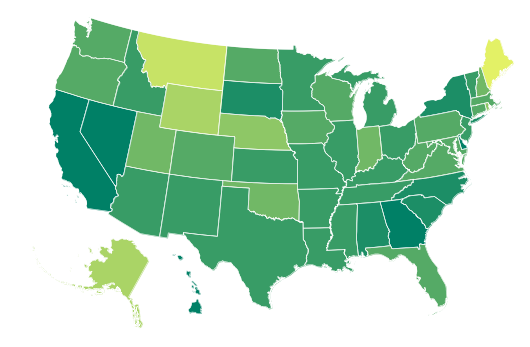

In [22]:
# Map results
num_colors = 9
values = swm['PECERT_w']
cm = plt.get_cmap('summer')
scheme = cm(1.*np.arange(num_colors)/num_colors)
bins = np.linspace(values.min(), values.max(), num_colors)
swm['bin'] = np.digitize(values, bins) - 1
#mpl.style.use('seaborn-white')

m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

plt.gcf()
fig = plt.figure(figsize=(12,6))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('st99_d00', 'states', drawbounds=True, color='#ffffff')
ax = plt.gca()
ax.axis('off')

for info, shape in zip(m.states_info, m.states):
    s = int(info['STATE'])
    if info['NAME'] in ['Alaska', 'Hawaii']:
        # Only include the 8 main islands of Hawaii 
        if info['NAME'] == 'Hawaii' and float(info['AREA']) > 0.005:
            shape = [(i[0] + 5200000, i[1] - 1400000) for i in shape]
        # Alaska is large. Rescale it.
        elif info['NAME'] == 'Alaska':
            shape = [(i[0]*0.35 + 1100000, i[1]*0.35 -1300000) for i in shape]
        poly = Polygon(shape, facecolor=scheme[int(swm.loc[s]['bin'])], edgecolor='#ffffff', linewidth=.5)
        ax.add_patch(poly)
        
    if s not in swm.index:
        color = '#dddddd'
    else:
        color = scheme[int(swm.loc[s]['bin'])]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches, edgecolor='#ffffff', lw=.1, alpha=1.)
    pc.set_facecolor(color)
    ax.add_collection(pc)

plt.savefig('test2.pdf', bbox_inches='tight', pad_inches=.2, dpi=300)